# Performance

In [1]:
import platform
import psutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor']='white'
plt.rcParams['font.size']=16

import bioframe
import pyranges

In [2]:
print(f"Bioframe v.{bioframe.__version__}")
print(f"PyRanges v.{pyranges.__version__}")
print(f"System Platform: {platform.platform()}")
print(f"{psutil.cpu_count()} CPUs at {psutil.cpu_freq().current:.0f} GHz") 

Bioframe v.0.2.0
PyRanges v.0.0.95
System Platform: macOS-10.15.7-x86_64-i386-64bit
4 CPUs at 2300 GHz


In [3]:
def make_random_intervals(
        n=1e5, n_chroms=1, max_coord=None, max_length=10, categorical_chroms=False,
        sort=False
    ):
    n = int(n)
    n_chroms = int(n_chroms)
    max_coord = (n // n_chroms) if max_coord is None else int(max_coord)
    max_length = int(max_length)
    
    chroms = np.array(['chr'+str(i+1) for i in range(n_chroms)])[
        np.random.randint(0, n_chroms, n)]
    starts = np.random.randint(0, max_coord, n)
    ends = starts + np.random.randint(0, max_length, n)

    df = pd.DataFrame({
        'chrom':chroms,
        'start':starts,
        'end':ends
    })
    
    if categorical_chroms:
        df['chrom'] = df['chrom'].astype('category')

    if sort:
        df = df.sort_values(['chrom','start','end']).reset_index()
        
    return df


## Overlap

### vs number of intervals

In [4]:
timings = {}
for n in [1e2, 1e3, 1e4, 1e5, 1e6]:
    df = make_random_intervals(n=n, n_chroms=1)
    df2 = make_random_intervals(n=n, n_chroms=1)
    timings[n] = %timeit -o -r 1 bioframe.overlap(df, df2)

8.26 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
9.55 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
42.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
368 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
5.54 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


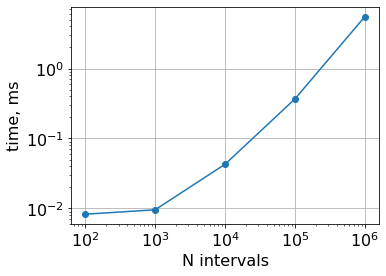

In [5]:
plt.loglog(
    list(timings.keys()),
    list([r.average for r in timings.values()]),
    'o-',
)
plt.xlabel('N intervals')
plt.ylabel('time, ms')
plt.gca().set_aspect(1.0)
plt.grid()

#### vs total number of intersections

In [6]:
timings = {}
n_intersections = {}
n = 1e4
for avg_interval_len in [3, 1e1, 3e1, 1e2, 3e2]:
    df = make_random_intervals(n=n, n_chroms=1, max_length=avg_interval_len*2)
    df2 = make_random_intervals(n=n, n_chroms=1, max_length=avg_interval_len*2)
    timings[avg_interval_len] = %timeit -o -r 1 bioframe.overlap(df, df2)
    n_intersections[avg_interval_len] = bioframe.overlap(df, df2).shape[0]

26.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
58.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
176 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
579 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


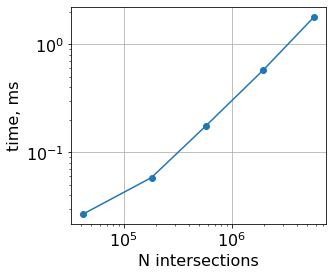

In [7]:
plt.loglog(
    list(n_intersections.values()),
    list([r.average for r in timings.values()]),
    'o-',
)
plt.xlabel('N intersections')
plt.ylabel('time, ms')
plt.gca().set_aspect(1.0)
plt.grid()

#### vs number of chromosomes

In [8]:
timings = {}
n_intersections = {}
n = 1e5
for n_chroms in [1, 3, 10, 30, 100, 300, 1000]:
    df = make_random_intervals(n, n_chroms)
    df2 = make_random_intervals(n, n_chroms)
    timings[n_chroms] = %timeit -o -r 1 bioframe.overlap(df, df2)
    n_intersections[n_chroms] = bioframe.overlap(df, df2).shape[0]


353 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
399 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
351 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
382 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
334 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
448 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
509 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [9]:
n_intersections

{1: 808885,
 3: 808242,
 10: 808475,
 30: 809528,
 100: 809998,
 300: 804316,
 1000: 786443}

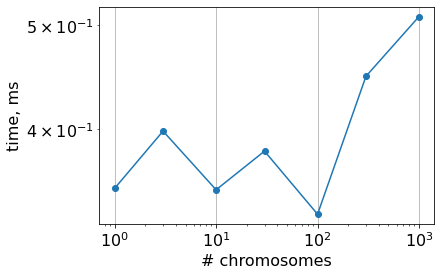

In [10]:
plt.loglog(
    list(timings.keys()),
    list([r.average for r in timings.values()]),
    'o-',
)
plt.xlabel('# chromosomes')
plt.ylabel('time, ms')
# plt.gca().set_aspect(1.0)
plt.grid()

#### vs other parameters: join type, sorted or categorical inputs

In [11]:
df = make_random_intervals()
df2 = make_random_intervals()

%timeit -r 1 bioframe.overlap(df, df2)
%timeit -r 1 bioframe.overlap(df, df2, how='inner')
%timeit -r 1 bioframe.overlap(df, df2, how='left')

383 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
234 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
357 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [12]:
df = make_random_intervals()
df2 = make_random_intervals()

%timeit -r 1 bioframe.overlap(df, df2)
%timeit -r 1 bioframe.overlap(df, df2, return_overlap=True)
%timeit -r 1 bioframe.overlap(df, df2, keep_order=True)

419 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
442 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
567 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [13]:
df = make_random_intervals()
df2 = make_random_intervals()

%timeit -r 1 bioframe.overlap(df, df2)
%timeit -r 1 bioframe.overlap(df, df2, how='inner')
%timeit -r 1 bioframe.ops._overlap_intidxs(df, df2)
%timeit -r 1 bioframe.ops._overlap_intidxs(df, df2, how='inner')

378 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
230 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
121 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
112 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


In [14]:
print('Default inputs (outer/inner joins):')
df = make_random_intervals()
df2 = make_random_intervals()

%timeit -r 1 bioframe.overlap(df, df2)
%timeit -r 1 bioframe.overlap(df, df2, how='inner')

print('Sorted inputs (outer/inner joins):')
df_sorted = make_random_intervals(sort=True)
df2_sorted = make_random_intervals(sort=True)

%timeit -r 1 bioframe.overlap(df_sorted, df2_sorted)
%timeit -r 1 bioframe.overlap(df_sorted, df2_sorted, how='inner')

print('Categorical chromosomes (outer/inner joins):')
df_cat = make_random_intervals(categorical_chroms=True)
df2_cat = make_random_intervals(categorical_chroms=True)

%timeit -r 1 bioframe.overlap(df_cat, df2_cat)
%timeit -r 1 bioframe.overlap(df_cat, df2_cat, how='inner')

Default inputs (outer/inner joins):
389 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
245 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Sorted inputs (outer/inner joins):
451 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
325 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Categorical chromosomes (outer/inner joins):
342 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
188 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


## Vs Pyranges

### Default arguments

In [15]:
def df2pr(df):
    return pyranges.PyRanges(
    chromosomes=df.chrom,
    starts=df.start,
    ends=df.end,
    )

In [16]:
timings_bf = {}
timings_pr = {}
for n in [1e2, 1e3, 1e4, 1e5, 1e6]:
    df = make_random_intervals(n=n, n_chroms=1)
    df2 = make_random_intervals(n=n, n_chroms=1)
    pr = df2pr(df)
    pr2 = df2pr(df2)
    timings_bf[n] = %timeit -o -r 1 bioframe.overlap(df, df2)
    timings_pr[n] = %timeit -o -r 1 pr.intersect(pr2)
    

8.34 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
4.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
12.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
7.23 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
42.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
16.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
389 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
120 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
5.64 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.74 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


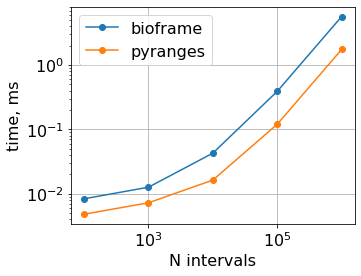

In [17]:
plt.loglog(
    list(timings_bf.keys()),
    list([r.average for r in timings_bf.values()]),
    'o-',
    label='bioframe'
)
plt.loglog(
    list(timings_pr.keys()),
    list([r.average for r in timings_pr.values()]),
    'o-',
    label='pyranges'
)
plt.xlabel('N intervals')
plt.ylabel('time, ms')
plt.gca().set_aspect(1.0)
plt.grid()
plt.legend()

#### +conversion from/into dataframes +"inner" join type

In [18]:
timings_bf = {}
timings_pr = {}
for n in [1e2, 1e3, 1e4, 1e5, 1e6, 3e6]:
    df = make_random_intervals(n=n, n_chroms=1)
    df2 = make_random_intervals(n=n, n_chroms=1)
    timings_bf[n] = %timeit -o -r 1 bioframe.overlap(df, df2, how='inner')
    timings_pr[n] = %timeit -o -r 1 df2pr(df).intersect(df2pr(df2)).as_df()
    

5.28 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
13 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
4.31 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
16.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
23.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
39.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
254 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
198 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
5.02 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.68 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
14.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
9.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


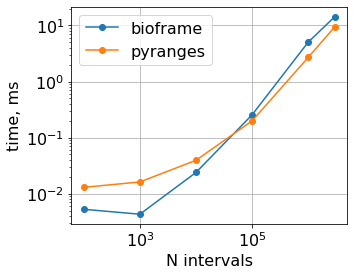

In [19]:
plt.loglog(
    list(timings_bf.keys()),
    list([r.average for r in timings_bf.values()]),
    'o-',
    label='bioframe'
)
plt.loglog(
    list(timings_pr.keys()),
    list([r.average for r in timings_pr.values()]),
    'o-',
    label='pyranges'
)
plt.xlabel('N intervals')
plt.ylabel('time, ms')
plt.gca().set_aspect(1.0)
plt.grid()
plt.legend()

### Slicing 

In [20]:
timings_bf = {}
timings_pr = {}
for n in [1e2, 1e3, 1e4, 1e5, 1e6, 3e6]:
    df = make_random_intervals(n=n, n_chroms=1)
    timings_bf[n] = %timeit -o -r 1 bioframe.select(df, ('chr1', n//2, n//4*3))
    pr = df2pr(df)
    timings_pr[n] = %timeit -o -r 1 pr['chr1', n//2:n//4*3]
    

178 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
1.25 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
210 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
1.51 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
709 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
3.63 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
3.62 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
25.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
39.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
291 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
109 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
965 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


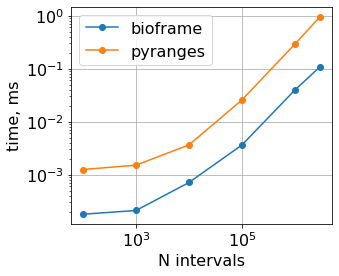

In [21]:
plt.loglog(
    list(timings_bf.keys()),
    list([r.average for r in timings_bf.values()]),
    'o-',
    label='bioframe'
)

plt.loglog(
    list(timings_pr.keys()),
    list([r.average for r in timings_pr.values()]),
    'o-',
    label='pyranges'
)
plt.xlabel('N intervals')
plt.ylabel('time, ms')
plt.gca().set_aspect(1.0)
plt.grid()
plt.legend()

In [22]:


# %timeit intarr=pd.IntervalIndex.from_arrays(starts1, ends1)

# %timeit intarr=pd.IntervalIndex.from_arrays(starts1, ends1)

# %timeit intarr.overlaps(pd.Interval(500000,600000))

# %timeit (starts1<=600000)&(ends1>=500000)